In [1]:
import torch.nn as nn
import torch 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt

# NN Classification (Perceptron) : gender

## Data preparation

### Load data: NOUN, ADJ, and both

In [2]:
df_nouns_we = pd.read_csv('../Data/FlauBERT_WE/all_nouns_we.csv').drop(columns=["number"])
df_adj_we = pd.read_csv('../Data/FlauBERT_WE/all_adjectives_we.csv').drop(columns = "number")
df_both_we = pd.concat([df_nouns_we, df_adj_we], ignore_index=True)

# target : gender
Y_gd_N = df_nouns_we["gender"].apply(lambda x: 1 if x == "masculine" else 0)
Y_gd_A = df_adj_we["gender"].apply(lambda x: 1 if x == "masculine" else 0)
Y_gd_both = df_both_we["gender"].apply(lambda x: 1 if x == "masculine" else 0)

# features : word embeddings dimensions
X_gd_N = df_nouns_we.drop(columns=["Word", "gender"])
X_gd_A = df_adj_we.drop(columns=["Word", "gender"])
X_gd_both = df_both_we.drop(columns = ["Word", "gender"] )

# normalize data to be between 0 and 1
X_gd_N = (X_gd_N - X_gd_N.min()) / (X_gd_N.max() - X_gd_N.min())
X_gd_A = (X_gd_A - X_gd_A.min()) / (X_gd_A.max() - X_gd_A.min())
X_gd_both = (X_gd_both - X_gd_both.min()) / (X_gd_both.max() - X_gd_both.min())

# split data into train and test sets
X_gd_N_train, X_gd_N_test, Y_gd_N_train, Y_gd_N_test = train_test_split(X_gd_N, Y_gd_N, test_size=0.2, random_state=42)
X_gd_A_train, X_gd_A_test, Y_gd_A_train, Y_gd_A_test = train_test_split(X_gd_A, Y_gd_A, test_size=0.2, random_state=42)
X_gd_both_train, X_gd_both_test, Y_gd_both_train, Y_gd_both_test = train_test_split(X_gd_both, Y_gd_both, test_size=0.2, random_state=42)

In [3]:
# print all the shapes
print("X_gd_N_train shape : ", X_gd_N_train.shape)
print("X_gd_N_test shape : ", X_gd_N_test.shape)
print("Y_gd_N_train shape : ", Y_gd_N_train.shape)
print("Y_gd_N_test shape : ", Y_gd_N_test.shape)
print("X_gd_A_train shape : ", X_gd_A_train.shape)
print("X_gd_A_test shape : ", X_gd_A_test.shape)
print("Y_gd_A_train shape : ", Y_gd_A_train.shape)
print("Y_gd_A_test shape : ", Y_gd_A_test.shape)
print("X_gd_both_train shape : ", X_gd_both_train.shape)
print("X_gd_both_test shape : ", X_gd_both_test.shape)

X_gd_N_train shape :  (10590, 512)
X_gd_N_test shape :  (2648, 512)
Y_gd_N_train shape :  (10590,)
Y_gd_N_test shape :  (2648,)
X_gd_A_train shape :  (5067, 512)
X_gd_A_test shape :  (1267, 512)
Y_gd_A_train shape :  (5067,)
Y_gd_A_test shape :  (1267,)
X_gd_both_train shape :  (15657, 512)
X_gd_both_test shape :  (3915, 512)


In [4]:
train_features = [X_gd_N_train, X_gd_A_train, X_gd_both_train]
test_features = [X_gd_N_test, X_gd_A_test, X_gd_both_test]
train_targets = [Y_gd_N_train, Y_gd_A_train, Y_gd_both_train]
test_targets = [Y_gd_N_test, Y_gd_A_test, Y_gd_both_test]

### Tensors

In [5]:
# convert to tensors
train_features = [torch.tensor(x.values).float() for x in train_features]
test_features = [torch.tensor(x.values).float() for x in test_features]
train_targets = [torch.tensor(x.values).long() for x in train_targets]
test_targets = [torch.tensor(x.values).long() for x in test_targets]

In [6]:
from torch.utils.data import TensorDataset, DataLoader
# the TensorDataset is a ready to use class to represent your data as list of tensors. 
# Note that input_features and labels must match on the length of the first dimension
train_sets = [TensorDataset(X_train, Y_train) for X_train, Y_train in zip(train_features, train_targets)]
test_sets = [TensorDataset(X_valid, Y_valid) for X_valid, Y_valid in zip(test_features, test_targets)]

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers
train_loaders = [DataLoader(train_set, batch_size=32, shuffle=True) for train_set in train_sets]
test_loaders = [DataLoader(test_set, batch_size=32) for test_set in test_sets]

## Classification

### NN definition

In [46]:
NNlist = []

for i in range(3):
    
    # create a fully connected perceptron with 1 input layer (512 features) and 1 output layer 
    model = nn.Sequential(nn.Linear(512, 2), nn.Softmax(dim=1))
    # define the loss function
    loss_fn = nn.CrossEntropyLoss()
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # add the model to the list
    NNlist.append([model, loss_fn, optimizer])

## Train the models

In [47]:
nb_epochs = 100

In [48]:
# train the models 
for i in range(3):
    print("* Training model ", i)
    model, loss_fn, optimizer = NNlist[i]
    # put the model in training mode
    model.train()

    for epoch in range(nb_epochs):
        for X_train, Y_train in train_loaders[i]:
            # compute the model output
            Y_pred = model(X_train)
            # calculate loss
            loss = loss_fn(Y_pred, Y_train)
            # reset the gradients
            optimizer.zero_grad()
            # backpropagation
            loss.backward()
            # update model weights
            optimizer.step()

        if epoch % 10 == 0:
            print("--Epoch ", epoch, " Loss : ", loss.item())

* Training model  0
--Epoch  0  Loss :  0.6446561217308044
--Epoch  10  Loss :  0.49609577655792236
--Epoch  20  Loss :  0.41727888584136963
--Epoch  30  Loss :  0.4228721559047699
--Epoch  40  Loss :  0.365585595369339
--Epoch  50  Loss :  0.40482768416404724
--Epoch  60  Loss :  0.3909391760826111
--Epoch  70  Loss :  0.3541414439678192
--Epoch  80  Loss :  0.42284345626831055
--Epoch  90  Loss :  0.34615904092788696
* Training model  1
--Epoch  0  Loss :  0.5496562719345093
--Epoch  10  Loss :  0.41234076023101807
--Epoch  20  Loss :  0.3527165651321411
--Epoch  30  Loss :  0.3270902931690216
--Epoch  40  Loss :  0.3339618444442749
--Epoch  50  Loss :  0.38026201725006104
--Epoch  60  Loss :  0.38230860233306885
--Epoch  70  Loss :  0.34386029839515686
--Epoch  80  Loss :  0.3253473937511444
--Epoch  90  Loss :  0.4053548574447632
* Training model  2
--Epoch  0  Loss :  0.6017105579376221
--Epoch  10  Loss :  0.39421340823173523
--Epoch  20  Loss :  0.4415295720100403
--Epoch  30  L

Model  0 
 Accuracy :  0.9512839879154078
 Precision :  0.9417071342468262
 Recall :  0.9679030179977417
 F1 score :  0.9546254277229309
Confusion matrix : 


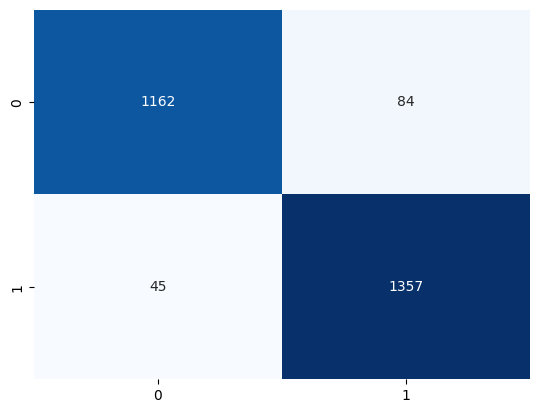

Model  1 
 Accuracy :  0.994475138121547
 Precision :  0.9949685335159302
 Recall :  0.996221661567688
 F1 score :  0.9955946803092957
Confusion matrix : 


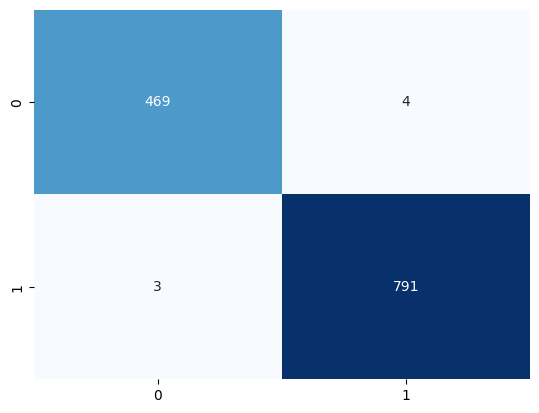

Model  2 
 Accuracy :  0.9560664112388251
 Precision :  0.95493084192276
 Recall :  0.967887818813324
 F1 score :  0.9613656401634216
Confusion matrix : 


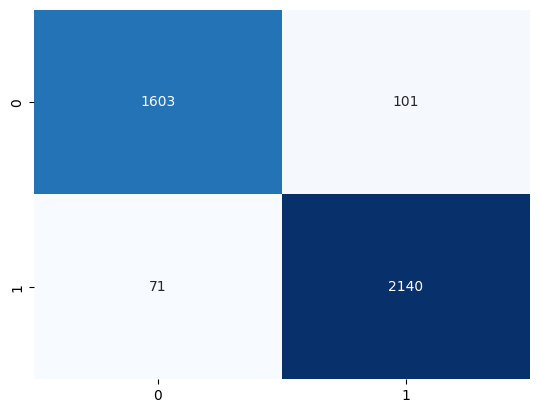

In [49]:
# display the confusion matrix
for i in range(3):

    # put the model in evaluation mode
    NNlist[i][0].eval()
    # initialize the number of correct predictions
    nb_correct_pred = 0
    # initialize the number of predictions
    nb_pred = 0
    # initialize the confusion matrix
    confusion_matrix = torch.zeros(2, 2)
    # iterate over batches
    for X_test, Y_test in test_loaders[i]:
        # compute the model output
        with torch.no_grad():
            Y_pred = NNlist[i][0](X_test)
            # get the predicted class
            Y_pred = torch.argmax(Y_pred, dim=1)
            # compute the number of correct predictions
            nb_correct_pred += (Y_pred == Y_test).sum().item()
            # compute the number of predictions
            nb_pred += Y_pred.shape[0]
            # update the confusion matrix
            for t, p in zip(Y_test.view(-1), Y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    # compute the accuracy
    accuracy = nb_correct_pred / nb_pred
    # compute the precision, recall and f1 score
    precision = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[0, 1])
    recall = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])
    f1_score = 2 * precision * recall / (precision + recall)
    # print the results
    print("Model ", i, "\n Accuracy : ", accuracy)
    print(" Precision : ", float(precision))
    print(" Recall : ", float(recall))
    print(" F1 score : ", float(f1_score))
    print("Confusion matrix : ")
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.show()

In [50]:
# get the weights of the first layer of the model trained on the three datasets
weights = [NNlist[i][0][0].weight.data.numpy() for i in range(3)]

In [51]:
print(weights[0].shape)
print(weights[0])

(2, 512)
[[ 0.84603596  0.3009222  -0.2858471  ...  0.45418143  0.630329
  -0.07349979]
 [-0.9011985  -0.30836713  0.26978102 ... -0.4486797  -0.65319985
   0.08126774]]


In [52]:
# store the weights in a pandas dataframe
weights_df = pd.DataFrame(weights[0], columns=X_gd_N_train.columns)
weights_df['dataset'] = 'N'
weights_df = weights_df.append(pd.DataFrame(weights[1], columns=X_gd_A_train.columns))
weights_df['dataset'] = weights_df['dataset'].fillna('A')
weights_df = weights_df.append(pd.DataFrame(weights[2], columns=X_gd_both_train.columns))
weights_df['dataset'] = weights_df['dataset'].fillna('both')

# set the dataset as index
weights_df = weights_df.set_index('dataset')

C:\Users\bleuze3u\AppData\Local\Temp\ipykernel_3136\2365961212.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights_df = weights_df.append(pd.DataFrame(weights[1], columns=X_gd_A_train.columns))
C:\Users\bleuze3u\AppData\Local\Temp\ipykernel_3136\2365961212.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  weights_df = weights_df.append(pd.DataFrame(weights[2], columns=X_gd_both_train.columns))


In [53]:
weights_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
dataset,,,,,,,,,,,,,,,,,,,,,
N,0.846036,0.300922,-0.285847,-0.086823,0.787666,-1.134273,-0.223839,-1.624826,0.911758,0.426340,...,-0.264814,0.912214,-0.162907,0.522866,0.056498,-1.539892,-0.469072,0.454181,0.630329,-0.073500
N,-0.901199,-0.308367,0.269781,0.143071,-0.817327,1.119438,0.247629,1.626636,-0.915359,-0.393137,...,0.217716,-0.848450,0.178816,-0.542615,-0.122473,1.505519,0.501749,-0.448680,-0.653200,0.081268
A,0.565860,0.218716,-0.432030,-0.165197,0.487706,-1.292943,-0.275893,-0.647258,0.332452,0.406746,...,0.121187,0.984599,0.131558,0.281587,-0.498260,-0.983694,0.071034,0.193015,0.140102,0.555712
A,-0.589038,-0.261797,0.477376,0.189192,-0.488106,1.307083,0.300015,0.659518,-0.327100,-0.344491,...,-0.095963,-1.056302,-0.178114,-0.272043,0.531221,0.999070,-0.086591,-0.217111,-0.152982,-0.534711
both,1.147924,0.243077,-0.766639,0.012383,1.014780,-1.529853,-0.360777,-1.821895,1.062723,0.444499,...,-0.172867,1.193558,-0.106780,0.879802,-0.087658,-1.761862,-0.440605,0.579808,0.617684,-0.106696
both,-1.199610,-0.247595,0.775210,-0.021403,-0.953299,1.540445,0.354431,1.830138,-1.042678,-0.468110,...,0.178778,-1.195875,0.150716,-0.907878,0.037804,1.709094,0.457310,-0.610930,-0.565947,0.051822


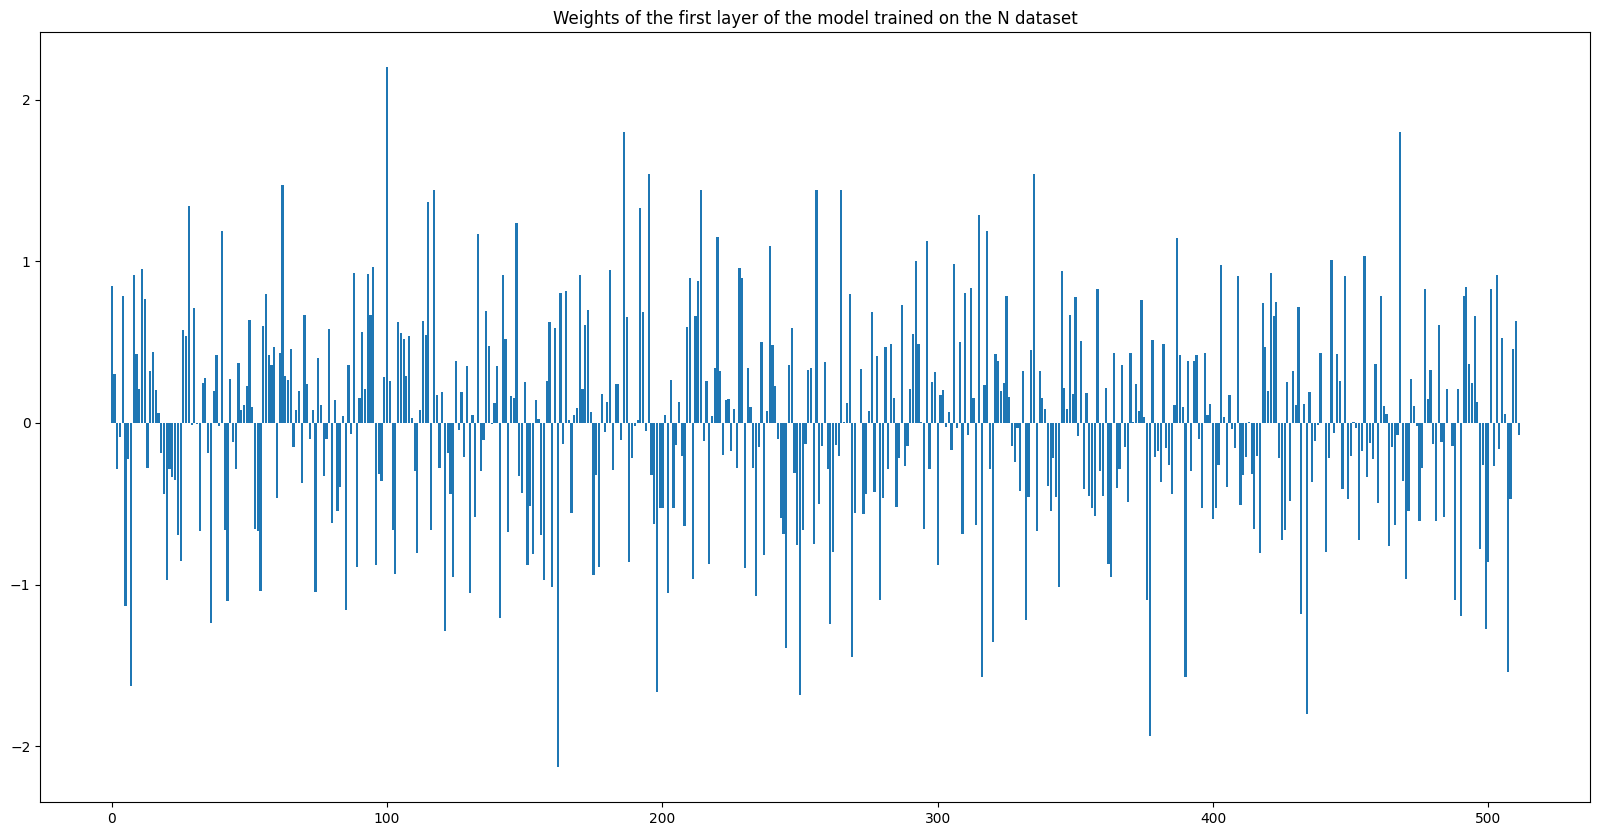

In [54]:
weights_N_0 = weights_df.iloc[0, :]
weights_N_0

# plot weights_N_0
plt.figure(figsize=(20, 10))
plt.bar(range(512), weights_N_0.values)
plt.title('Weights of the first layer of the model trained on the N dataset')
plt.show()

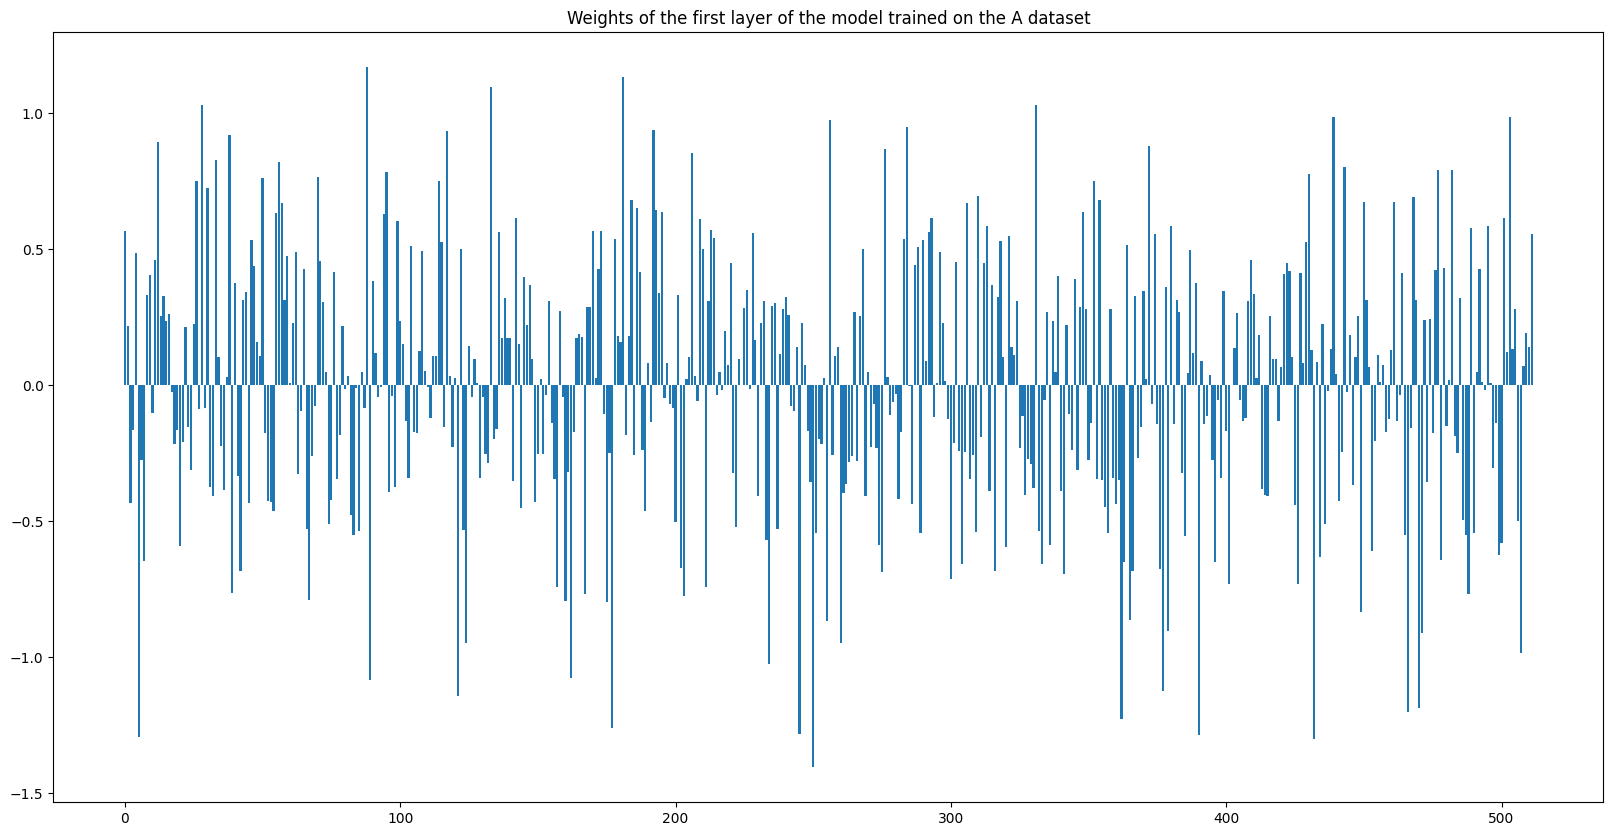

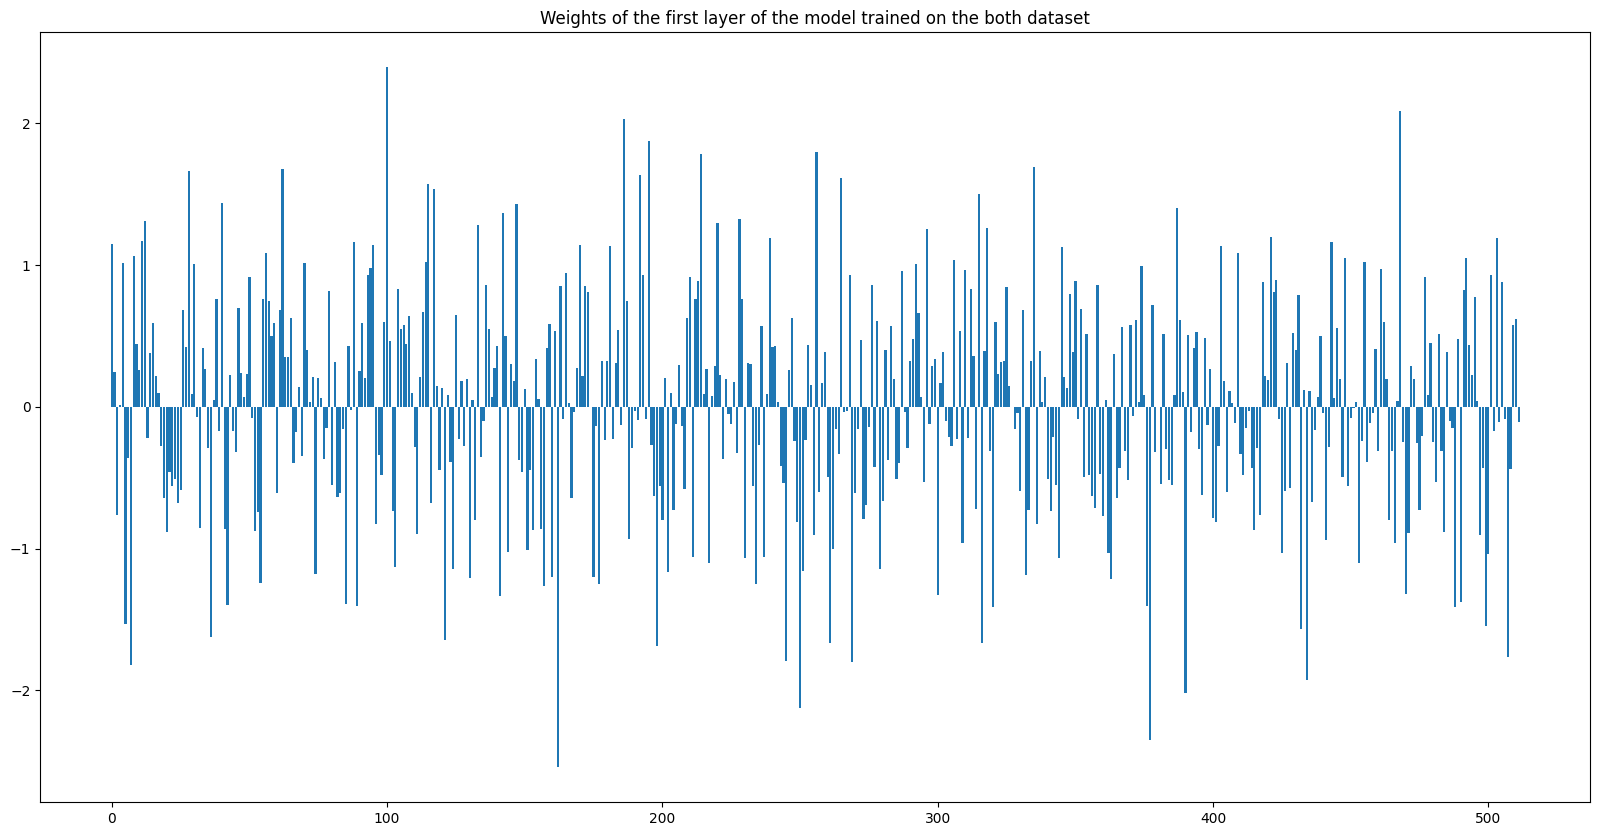

In [55]:
# do the same for the other datasets
weights_A_0 = weights_df.iloc[2, :]
weights_both_0 = weights_df.iloc[4, :]

plt.figure(figsize=(20, 10))
plt.bar(range(512), weights_A_0.values)
plt.title('Weights of the first layer of the model trained on the A dataset')
plt.show()

plt.figure(figsize=(20, 10))
plt.bar(range(512), weights_both_0.values)
plt.title('Weights of the first layer of the model trained on the both dataset')
plt.show()

In [60]:
sorted_features = []
for i in range(3):
    # get the list of weights ordered by decreasing absolute value
    to_sort = weights[i][0]
    to_sort = np.abs(to_sort)
    sorted = np.argsort(to_sort)[::-1]
    sorted_features.append(sorted)

In [57]:
for i in range(3):
    print("Model ", i, " : \n")
    for feat in sorted_features[i][:10]:
        print(f"{int(feat)}: {weights[i][0][int(feat)]}    {weights[i][1][int(feat)]}")

Model  0  : 

100: 2.19944167137146    -2.2513294219970703
162: -2.1300923824310303    2.123279333114624
377: -1.9380122423171997    1.9243108034133911
434: -1.801861047744751    1.7854807376861572
468: 1.8014354705810547    -1.7458502054214478
186: 1.7960628271102905    -1.8091410398483276
250: -1.6841437816619873    1.6685526371002197
198: -1.662035584449768    1.6590996980667114
7: -1.6248260736465454    1.6266359090805054
390: -1.5721120834350586    1.5593373775482178
Model  1  : 

250: -1.4046638011932373    1.397172212600708
432: -1.302107334136963    1.275029182434082
5: -1.2929431200027466    1.307083249092102
390: -1.2873727083206177    1.2675992250442505
245: -1.2830076217651367    1.2694462537765503
177: -1.2613581418991089    1.2622278928756714
362: -1.2258436679840088    1.236374020576477
466: -1.201432228088379    1.2068731784820557
470: -1.1853488683700562    1.1636061668395996
88: 1.168611764907837    -1.1637827157974243
Model  2  : 

162: -2.5429389476776123    2.54327

# NN Classification (Perceptron) : Number

In [2]:
df_nouns_we = pd.read_csv('../Data/FlauBERT_WE/all_nouns_we.csv').drop(columns=["gender"])
df_adj_we = pd.read_csv('../Data/FlauBERT_WE/all_adjectives_we.csv').drop(columns = "gender")
df_both_we = pd.concat([df_nouns_we, df_adj_we], ignore_index=True)
# target : number
Y_nb_N = df_nouns_we["number"].apply(lambda x: 1 if x == "singular" else 0)
Y_nb_A = df_adj_we["number"].apply(lambda x: 1 if x == "singular" else 0)
Y_nb_both = df_both_we["number"].apply(lambda x: 1 if x == "singular" else 0)
# features : word embeddings dimensions
X_nb_N = df_nouns_we.drop(columns=["Word", "number"])
X_nb_A = df_adj_we.drop(columns=["Word", "number"])
X_nb_both = df_both_we.drop(columns = ["Word", "number"] )

# normalize data to be between 0 and 1
X_nb_N = (X_nb_N - X_nb_N.min()) / (X_nb_N.max() - X_nb_N.min())
X_nb_A = (X_nb_A - X_nb_A.min()) / (X_nb_A.max() - X_nb_A.min())
X_nb_both = (X_nb_both - X_nb_both.min()) / (X_nb_both.max() - X_nb_both.min())


# split data into train and test sets
X_nb_N_train, X_nb_N_test, Y_nb_N_train, Y_nb_N_test = train_test_split(X_nb_N, Y_nb_N, test_size=0.2, random_state=42)
X_nb_A_train, X_nb_A_test, Y_nb_A_train, Y_nb_A_test = train_test_split(X_nb_A, Y_nb_A, test_size=0.2, random_state=42)
X_nb_both_train, X_nb_both_test, Y_nb_both_train, Y_nb_both_test = train_test_split(X_nb_both, Y_nb_both, test_size=0.2, random_state=42)

In [3]:
# print all the shapes
print("X_nb_N_train shape : ", X_nb_N_train.shape)
print("X_nb_N_test shape : ", X_nb_N_test.shape)
print("Y_nb_N_train shape : ", Y_nb_N_train.shape)
print("Y_nb_N_test shape : ", Y_nb_N_test.shape)
print("X_nb_A_train shape : ", X_nb_A_train.shape)
print("X_nb_A_test shape : ", X_nb_A_test.shape)
print("Y_nb_A_train shape : ", Y_nb_A_train.shape)
print("Y_nb_A_test shape : ", Y_nb_A_test.shape)
print("X_nb_both_train shape : ", X_nb_both_train.shape)
print("X_nb_both_test shape : ", X_nb_both_test.shape)

X_nb_N_train shape :  (10590, 512)
X_nb_N_test shape :  (2648, 512)
Y_nb_N_train shape :  (10590,)
Y_nb_N_test shape :  (2648,)
X_nb_A_train shape :  (5067, 512)
X_nb_A_test shape :  (1267, 512)
Y_nb_A_train shape :  (5067,)
Y_nb_A_test shape :  (1267,)
X_nb_both_train shape :  (15657, 512)
X_nb_both_test shape :  (3915, 512)


In [4]:
train_feature = [X_nb_N_train, X_nb_A_train, X_nb_both_train]
test_feature = [X_nb_N_test, X_nb_A_test, X_nb_both_test]
train_target = [Y_nb_N_train, Y_nb_A_train, Y_nb_both_train]
test_target = [Y_nb_N_test, Y_nb_A_test, Y_nb_both_test]

### Tensors

In [5]:
# convert to tensors
train_feature = [torch.tensor(x.values).float() for x in train_feature]
test_feature = [torch.tensor(x.values).float() for x in test_feature]
train_target = [torch.tensor(x.values).long() for x in train_target]
test_target = [torch.tensor(x.values).long() for x in test_target]

In [6]:
from torch.utils.data import TensorDataset, DataLoader
# the TensorDataset is a ready to use class to represent your data as list of tensors. 
# Note that input_features and labels must match on the length of the first dimension
train_sets = [TensorDataset(X_train, Y_train) for X_train, Y_train in zip(train_feature, train_target)]
test_sets = [TensorDataset(X_valid, Y_valid) for X_valid, Y_valid in zip(test_feature, test_target)]

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers
train_loaders = [DataLoader(train_set, batch_size=32, shuffle=True) for train_set in train_sets]
test_loaders = [DataLoader(test_set, batch_size=32) for test_set in test_sets]

## Classification

In [9]:
NNlist = []

for i in range(3):
    
    # create a fully connected perceptron with 1 input layer (512 features) and 1 output layer (2 classes)
    model = nn.Sequential(nn.Linear(512, 2), nn.Softmax(dim=1))
    # define the loss function
    loss_fn = nn.CrossEntropyLoss()
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # add the model to the list
    NNlist.append([model, loss_fn, optimizer])

## Train the models

In [10]:
nb_epochs = 100
# train the models 
for i in range(3):
    print("* Training model ", i)
    model, loss_fn, optimizer = NNlist[i]
    # put the model in training mode
    model.train()
    for epoch in range(nb_epochs):
        for X_train, Y_train in train_loaders[i]:
            # compute the model output
            Y_pred = model(X_train)
            # calculate loss
            loss = loss_fn(Y_pred, Y_train)
            # reset the gradients
            optimizer.zero_grad()
            # backpropagation
            loss.backward()
            # update model weights
            optimizer.step()

        if epoch % 10 == 0:
            print("--Epoch ", epoch, " Loss : ", loss.item())

* Training model  0
--Epoch  0  Loss :  0.5440499186515808
--Epoch  10  Loss :  0.3528536856174469
--Epoch  20  Loss :  0.3297676742076874
--Epoch  30  Loss :  0.33709916472435
--Epoch  40  Loss :  0.3687392473220825
--Epoch  50  Loss :  0.3336738049983978
--Epoch  60  Loss :  0.31871163845062256
--Epoch  70  Loss :  0.3264993131160736
--Epoch  80  Loss :  0.32264789938926697
--Epoch  90  Loss :  0.31724223494529724
* Training model  1
--Epoch  0  Loss :  0.598804235458374
--Epoch  10  Loss :  0.3743787705898285
--Epoch  20  Loss :  0.4013937711715698
--Epoch  30  Loss :  0.3459959328174591
--Epoch  40  Loss :  0.33310461044311523
--Epoch  50  Loss :  0.3210395574569702
--Epoch  60  Loss :  0.3290303349494934
--Epoch  70  Loss :  0.3172324001789093
--Epoch  80  Loss :  0.3195200562477112
--Epoch  90  Loss :  0.32089078426361084
* Training model  2
--Epoch  0  Loss :  0.4789024591445923
--Epoch  10  Loss :  0.3276904821395874
--Epoch  20  Loss :  0.32392215728759766
--Epoch  30  Loss : 

Model  0 
 Accuracy :  0.9928247734138973
 Precision :  0.9953703880310059
 Recall :  0.9936453104019165
 F1 score :  0.9945071339607239
Confusion matrix : 


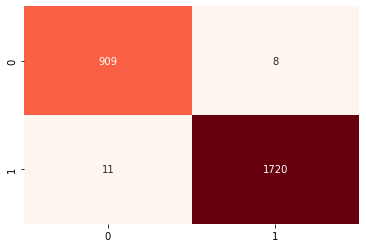

Model  1 
 Accuracy :  0.994475138121547
 Precision :  0.9962406158447266
 Recall :  0.9949937462806702
 F1 score :  0.9956168532371521
Confusion matrix : 


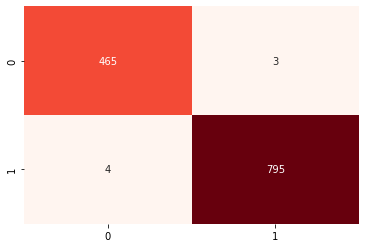

Model  2 
 Accuracy :  0.9936143039591315
 Precision :  0.9936733841896057
 Recall :  0.9964314103126526
 F1 score :  0.9950504899024963
Confusion matrix : 


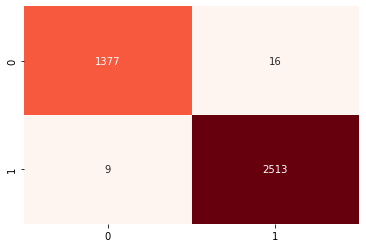

In [11]:
# display the confusion matrix
for i in range(3):

    # put the model in evaluation mode
    NNlist[i][0].eval()
    # initialize the number of correct predictions
    nb_correct_pred = 0
    # initialize the number of predictions
    nb_pred = 0
    # initialize the confusion matrix
    confusion_matrix = torch.zeros(2, 2)
    # iterate over batches
    for X_test, Y_test in test_loaders[i]:
        # compute the model output
        with torch.no_grad():
            Y_pred = NNlist[i][0](X_test)
            # get the predicted class
            Y_pred = torch.argmax(Y_pred, dim=1)
            # compute the number of correct predictions
            nb_correct_pred += (Y_pred == Y_test).sum().item()
            # compute the number of predictions
            nb_pred += Y_pred.shape[0]
            # update the confusion matrix
            for t, p in zip(Y_test.view(-1), Y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    # compute the accuracy
    accuracy = nb_correct_pred / nb_pred
    # compute the precision, recall and f1 score
    precision = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[0, 1])
    recall = confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])
    f1_score = 2 * precision * recall / (precision + recall)
    # print the results
    print("Model ", i, "\n Accuracy : ", accuracy)
    print(" Precision : ", float(precision))
    print(" Recall : ", float(recall))
    print(" F1 score : ", float(f1_score))
    print("Confusion matrix : ")
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Reds', cbar=False)
    plt.show()

In [12]:
# get the weights of the first layer of the model trained on the three datasets
weights = [NNlist[i][0][0].weight.data.numpy() for i in range(3)]
print(weights[0].shape)
print(weights[0])

(2, 512)
[[-0.05428017  0.8474955  -0.2600719  ... -0.07665038 -0.49273592
   0.6974068 ]
 [ 0.09440201 -0.86792743  0.23487496 ...  0.13763265  0.4493265
  -0.70801145]]


In [13]:
# store the weights in a pandas dataframe
weight_df = pd.DataFrame(weights[0], columns=X_nb_N_train.columns)
weight_df['dataset'] = 'N'
weight_df = weight_df.append(pd.DataFrame(weights[1], columns=X_nb_A_train.columns))
weight_df['dataset'] = weight_df['dataset'].fillna('A')
weight_df = weight_df.append(pd.DataFrame(weights[2], columns=X_nb_both_train.columns))
weight_df['dataset'] = weight_df['dataset'].fillna('both')

# set the dataset as index
weight_df = weight_df.set_index('dataset')

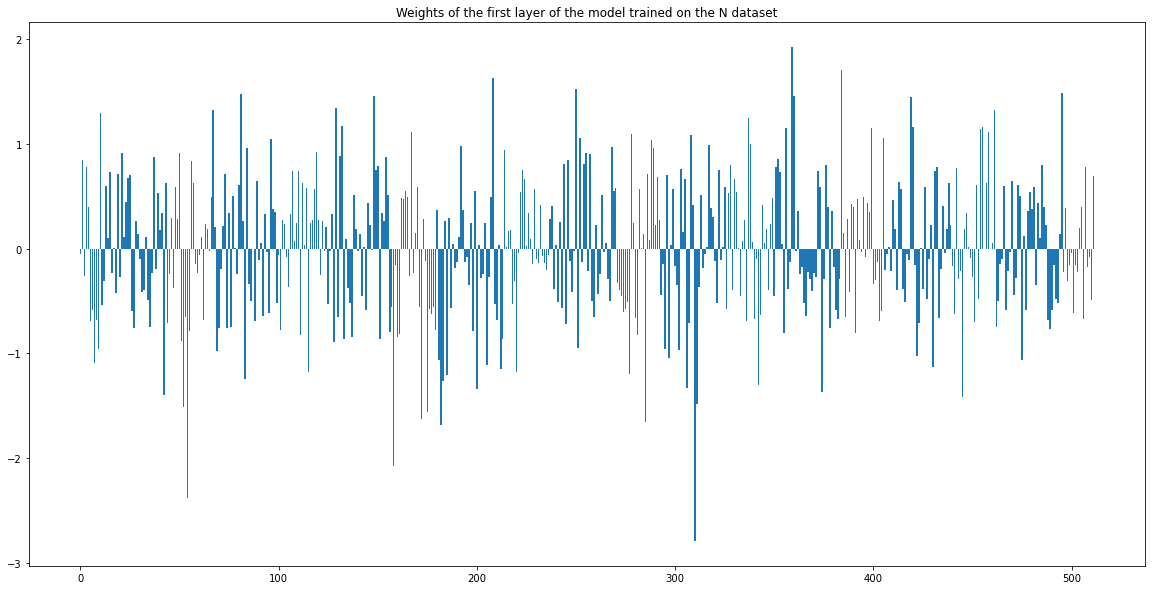

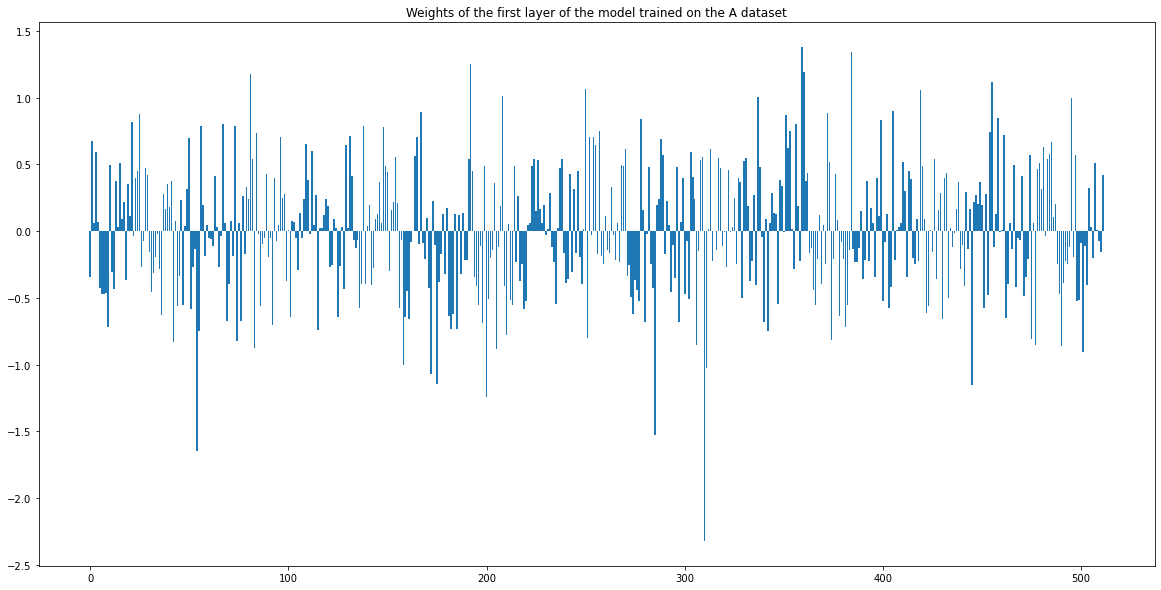

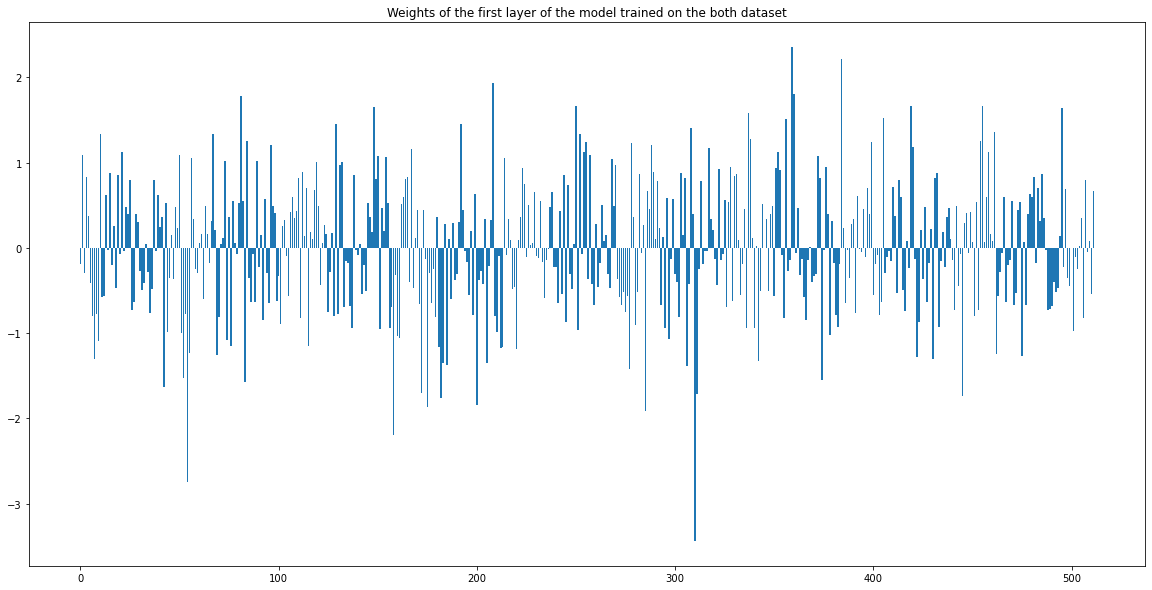

In [14]:
weight_N_0 = weight_df.iloc[0, :]
weight_N_0

# plot weights_N_0
plt.figure(figsize=(20, 10))
plt.bar(range(512), weight_N_0.values)
plt.title('Weights of the first layer of the model trained on the N dataset')
plt.show()

# do the same for the other datasets
weight_A_0 = weight_df.iloc[2, :]
weight_both_0 = weight_df.iloc[4, :]

plt.figure(figsize=(20, 10))
plt.bar(range(512), weight_A_0.values)
plt.title('Weights of the first layer of the model trained on the A dataset')
plt.show()

plt.figure(figsize=(20, 10))
plt.bar(range(512), weight_both_0.values)
plt.title('Weights of the first layer of the model trained on the both dataset')
plt.show()

In [15]:
sorted_feature = []
for i in range(3):
    # get the list of weights ordered by decreasing absolute value
    to_sort = weights[i][0]
    to_sort = np.abs(to_sort)
    sorted = np.argsort(to_sort)[::-1]
    sorted_feature.append(sorted)
for i in range(3):
    print("Model ", i, " : \n")
    for feat in sorted_feature[i][:10]:
        print(f"{int(feat)}: {weights[i][0][int(feat)]}    {weights[i][1][int(feat)]}")

Model  0  : 

310: -2.792752742767334    2.752384901046753
54: -2.3840601444244385    2.3914434909820557
158: -2.075476884841919    2.098706007003784
359: 1.9256991147994995    -1.951188564300537
384: 1.7078708410263062    -1.7339001893997192
182: -1.6865204572677612    1.6483664512634277
285: -1.6589934825897217    1.6918779611587524
208: 1.627899408340454    -1.6493594646453857
172: -1.6249306201934814    1.5960391759872437
175: -1.5643868446350098    1.5959937572479248
Model  1  : 

310: -2.321359634399414    2.2920455932617188
54: -1.647988200187683    1.6482157707214355
285: -1.5242090225219727    1.4959254264831543
359: 1.3792327642440796    -1.4213255643844604
384: 1.338271141052246    -1.3034344911575317
192: 1.252180814743042    -1.2543212175369263
200: -1.239863634109497    1.1974321603775024
360: 1.1877422332763672    -1.2232239246368408
81: 1.1762264966964722    -1.2452976703643799
445: -1.1541365385055542    1.0912978649139404
Model  2  : 

310: -3.4401397705078125    3.41